In [1]:
from my_packages import *
%matplotlib inline

data_folder = './data/'
pd.options.mode.chained_assignment = None
time_tracking = Time_Tracking()

# prepare data

In [2]:
time_tracking.start_tracking()
train_raw = pd.read_csv(data_folder + 'train_sample.csv')
gc.collect()
time_tracking.stop_tracking()

Time used: 0.0  minutes


In [3]:
# train, evaluate split 
data_index = np.arange(len(train_raw))
np.random.seed(123)
np.random.shuffle(data_index)

split_index = int(len(train_raw) * 0.7)
train_df, evaluate_df = train_raw.iloc[data_index[:split_index]], train_raw.iloc[data_index[split_index:]]
gc.collect()

0

# train and cross-validate

In [4]:
time_tracking.start_tracking()

our_model = MyXgbModel()
make_feat_param = {'sample_ratio':1, 'has_target':True, 'do_sample':True}

train_feat = our_model.make_feat_pipeline(train_df, make_feat_param)
gc.collect()

time_tracking.stop_tracking()

Time used: 0.0  minutes


In [5]:
train_param = {'eval_metric':'auc'}
train_x = train_feat.drop(['is_attributed', 'attributed_time'], axis =1)
train_y = train_feat['is_attributed']

train_cv, feat_importance = our_model.train(train_x, train_y, train_param)
gc.collect()
print('train cross-validation auc = {}'.format(round(train_cv,4)))

train cross-validation auc = 0.9523


Time used: 0.01  minutes


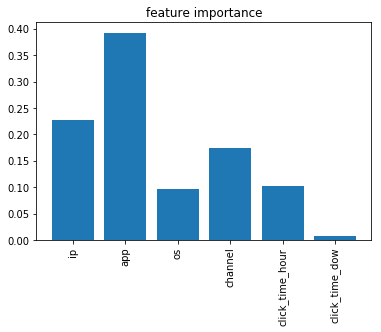

In [6]:
plt.bar(range(len(feat_importance)), feat_importance)
plt.xticks(range(len(feat_importance)), train_x.columns, rotation='vertical')
plt.title('feature importance')

time_tracking.stop_tracking()

# hyper-tune

[0.8796122000000001, 0.9049571999999999, 0.8714108000000002, 0.9111560000000001, 0.9268230000000001, 0.8994264, 0.899813, 0.9290108, 0.9207288, 0.9151372]


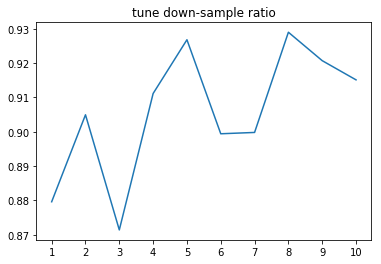

In [7]:
tune_auc = []
tune_range = np.arange(1, 11)

for sample_ratio in tune_range:

    make_feat_param = {'sample_ratio':sample_ratio, 'has_target':True, 'do_sample':True}

    our_model = MyXgbModel()
    evaluate_feat = our_model.make_feat_pipeline(evaluate_df, make_feat_param)
    x = evaluate_feat.drop(['is_attributed', 'attributed_time'], axis = 1)
    y = evaluate_feat['is_attributed']

    param = {'eval_metric':'auc'}
    train_cv, _ = our_model.train(x, y, param)

    tune_auc.extend([train_cv])

plt.figure()
plt.plot(tune_range, tune_auc)
plt.xticks(tune_range)
plt.title('tune down-sample ratio')

print(tune_auc)

# test

In [8]:
# read test raw file
time_tracking.start_tracking()
test_raw = pd.read_csv(data_folder + 'test.csv')
time_tracking.stop_tracking()

Time used: 0.29  minutes


In [18]:
time_tracking.start_tracking()
make_feat_param['do_sample'] = False
test_feat = our_model.make_feat_pipeline(test_raw, make_feat_param)
time_tracking.stop_tracking()

Time used: 19.73  minutes


In [20]:
time_tracking.start_tracking()
prediction = our_model.predict(test_feat.drop(['click_id'], axis =1))
time_tracking.stop_tracking()

Time used: 0.84  minutes


In [ ]:
time_tracking.start_tracking()
result = pd.DataFrame({'click_id':test_raw['click_id'], 'is_attributed':prediction})
result.to_csv(data_folder + 'result.csv', index = False)
time_tracking.stop_tracking()